In [61]:
'''Train an encoder using Contrastive Learning.'''
import argparse
import os
import subprocess
from collections import defaultdict

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torchlars import LARS
from tqdm import tqdm

from augmentation import ColourDistortion, TensorNormalise, ModuleCompose
from configs import get_datasets, get_mean_std
from critic import LinearCritic
from evaluate import save_checkpoint, encode_train_set, train_clf, test
from models import *
from scheduler import CosineAnnealingWithLinearRampLR
import matplotlib.pyplot as plt

In [52]:
device = 'cuda'

In [53]:
dataset = 'spirograph'
batch_size = 512
num_workers = 2
trainset, testset, clftrainset, num_classes, stem, col_distort, batch_transform = get_datasets(dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)

In [58]:
t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
for batch_idx, (inputs, _, _) in t:
        x1, x2 = inputs
        x1, x2 = x1.to(device), x2.to(device)
        rn1, rn2 = col_distort.sample_random_numbers(x1.shape, x1.device), col_distort.sample_random_numbers(x2.shape, x2.device)
        shape = (x1.shape[0] * 100, *x1.shape[1:])
        if dataset == 'spirograph':
            rn_extra = col_distort.sample_random_numbers(shape, x1.device).reshape((100, x1.shape[0], 6))
        else:
            rn_extra = col_distort.sample_random_numbers(shape, x1.device).reshape((100, x1.shape[0], 4))
        x1, x2 = batch_transform(x1, rn1), batch_transform(x2, rn2)
        break

Loss: ****           | 0/196 [00:00<?, ?it/s]


In [68]:
x1.size()

torch.Size([512, 3, 32, 32])

In [128]:
def show(img,  filename = 'spirograph', save = False):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.tight_layout()
    if save == True:
        destination = os.path.join('./figures', filename)
        plt.savefig(destination, dpi = 150, transparent = True, bbox_inches = 'tight', pad_inches = 0)
    plt.show()

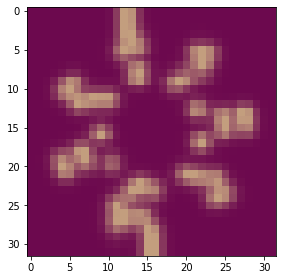

In [129]:
show(x1[0].detach().cpu(), 'spirograph1_1', save = True)

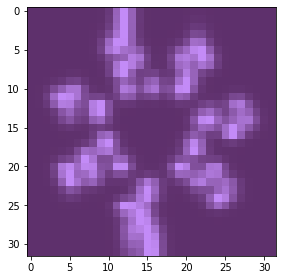

In [130]:
show(x2[0].detach().cpu(), 'spirograph1_2', save = True)

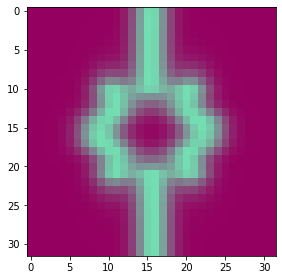

In [131]:
show(x1[6].detach().cpu(), 'spirograph2_1', save = True)

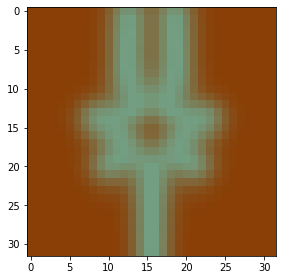

In [132]:
show(x2[6].detach().cpu(), 'spirograph2_2', save = True)

# Spirograph generate with different parameter

In [157]:
spirograph = DrawSpirograph(['m', 'b', 'sigma', 'rfore'], ['h', 'rback', 'gfore', 'gback', 'bfore', 'bback'])
stem = StemCIFAR
trainset, clftrainset, testset = spirograph.dataset()
num_classes = 3

In [158]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                          num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                         pin_memory=True)
clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)

In [174]:
t = tqdm(enumerate(trainloader), desc='Loss: **** ', total=len(trainloader), bar_format='{desc}{bar}{r_bar}')
for batch_idx, (inputs, _, _) in t:
        x1, x2 = inputs
        x1, x2 = x1.to(device), x2.to(device)
        x3 = x1.clone()
        x4 = x1.clone()
        rn1, rn2 = col_distort.sample_random_numbers(x1.shape, x1.device), col_distort.sample_random_numbers(x2.shape, x2.device)
        rn3, rn4 = col_distort.sample_random_numbers(x3.shape, x3.device), col_distort.sample_random_numbers(x4.shape, x4.device)
        shape = (x1.shape[0] * 100, *x1.shape[1:])
        if dataset == 'spirograph':
            rn_extra = col_distort.sample_random_numbers(shape, x1.device).reshape((100, x1.shape[0], 6))
        else:
            rn_extra = col_distort.sample_random_numbers(shape, x1.device).reshape((100, x1.shape[0], 4))
        x1, x2 = batch_transform(x1, rn1), batch_transform(x2, rn2)
        x3, x4 = batch_transform(x3, rn3), batch_transform(x4, rn4)
        break

Loss: ****           | 0/196 [00:00<?, ?it/s]


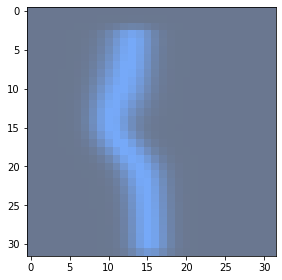

In [175]:
show(x1[0].detach().cpu(), 'spirograph_test', save = False)

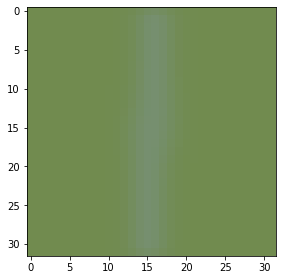

In [177]:
show(x2[0].detach().cpu(), 'spirograph_test', save = False)

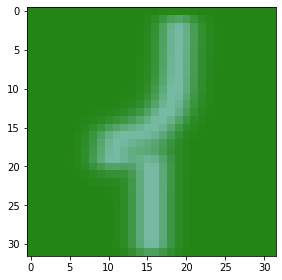

In [176]:
show(x3[0].detach().cpu(), 'spirograph_test', save = False)

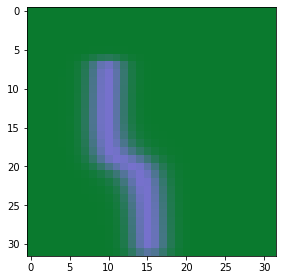

In [178]:
show(x4[0].detach().cpu(), 'spirograph_test', save = False)

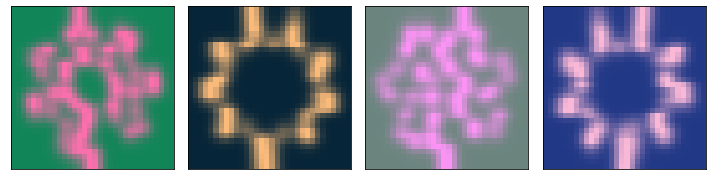

In [216]:
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 1
index = 14
x = [x1[index], x2[index], x3[index], x4[index]]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    npimg = np.array(x[i-1].detach().cpu())
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
destination = os.path.join('./figures', 'spirograph4pic_2')
plt.savefig(destination, dpi = 150, transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()


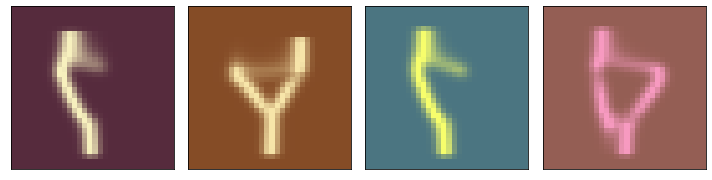

In [217]:
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 1
index = 18
x = [x1[index], x2[index], x3[index], x4[index]]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    npimg = np.array(x[i-1].detach().cpu())
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
destination = os.path.join('./figures', 'spirograph4pic_1')
plt.savefig(destination, dpi = 150, transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

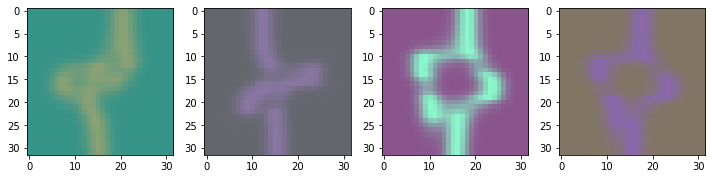

In [204]:
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 1
index = 2
x = [x1[index], x2[index], x3[index], x4[index]]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    npimg = np.array(x[i-1].detach().cpu())
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
plt.tight_layout()
plt.show()

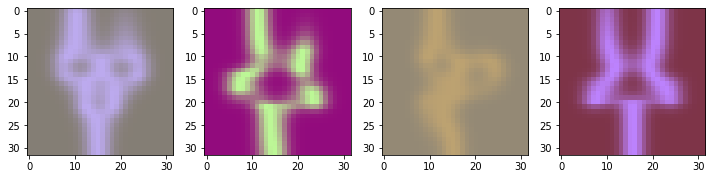

In [197]:
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 1
index = 7
x = [x1[index], x2[index], x3[index], x4[index]]
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    npimg = np.array(x[i-1].detach().cpu())
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
plt.tight_layout()
plt.show()

In [213]:
clftrainset[0]

(tensor([3.7514, 0.3547, 0.9153, 0.6568]),
 tensor([3.7514, 0.3547, 0.9153, 0.6568]))